In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/"
sz=224

In [4]:
torch.cuda.is_available()

False

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
os.listdir(PATH)

['.DS_Store', 'test', 'train', 'valid']

In [7]:
os.listdir(f'{PATH}valid')

['.DS_Store', 'kali', 'ringo']

In [9]:
files = os.listdir(f'{PATH}valid/ringo')[:5]
files

['r00001.jpg', 'r00002.jpg', 'r00004.jpg', 'r00011.jpg', 'r00024.jpg']

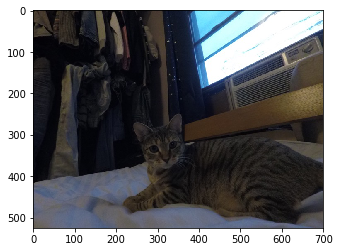

In [10]:
img = plt.imread(f'{PATH}valid/ringo/{files[0]}')
plt.imshow(img);

In [11]:
img.shape

(525, 700, 3)

In [12]:
img[:4,:4]

array([[[59, 50, 35],
        [53, 44, 29],
        [54, 45, 30],
        [65, 56, 41]],

       [[59, 50, 35],
        [53, 44, 29],
        [47, 38, 23],
        [50, 41, 26]],

       [[63, 54, 39],
        [57, 48, 33],
        [47, 38, 23],
        [43, 34, 19]],

       [[68, 59, 44],
        [64, 55, 40],
        [56, 47, 32],
        [53, 44, 29]]], dtype=uint8)

In [ ]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

In [ ]:
data.val_y

In [ ]:
data.classes

In [ ]:
log_preds = learn.predict()
log_preds.shape

In [ ]:
log_preds[:10]

In [ ]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])     

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [ ]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [ ]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [ ]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [ ]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

In [ ]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

In [ ]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

In [ ]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")